# Ephemeris object cube imaging (mosaic)

## Comet Giacobini-Zinner  -- work in progress

For imaigng of the sources that move significantly during the observations, proper ephemeris data need to be used. The following demo is one of the stadard procudures for processing of such data.

In [1]:
# extra packages needed
#import os
#os.system('pip install astropy')
#os.system('pip install aplpy')

In [2]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat
from casatools import measures, quanta, table, image
import os
from astropy.io import fits
from matplotlib import pylab as pl
import numpy as np
import aplpy
me = measures()
qa = quanta()
tb = table()
ia = image()

Define some useful funcitons
delete_tcleanimages: delete previous images from tclean run
get_attachedEphemtablepath: returns full eph table path for the corresponding field id

In [3]:
def delete_tcleanimages(imagename):
    ''' clean up images from a previous run '''
    imtypes = ['residual', 'image', 'psf', 'pb', 'model', 'sumwt']
    for type in imtypes:
        if os.path.exists(f'{imagename}.{type}'):
            os.system(f'rm -rf {imagename}.{type}')

In [4]:
def get_attachedEphemtablepath(msfile, fieldname):
    ''' returns full path of attached eph table for a specified field ID'''
    from casatools import table, msmetadata
    import glob
    _tb = table()
    _msmd = msmetadata()
    _msmd.open(msfile)
    fieldid = _msmd.fieldsforname(fieldname)[0]
    _msmd.close()
    _tb.open(msfile+'/FIELD')
    ephemid = _tb.getcell('EPHEMERIS_ID',fieldid)
    _tb.close()
    tabname = glob.glob(f'{msfile}/FIELD/EPHEM{ephemid}*/')
    return tabname[0]
    

## Imaging with epehemeris data attached to the MS

In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available.


In [5]:
datapath='/home/casa/data/casatestdata-large/stakeholder/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/stakeholder/alma/'

In [6]:
msfile=[datapath+'2017.1.00750.T_tclean_exe1.ms',datapath+'2017.1.00750.T_tclean_exe2.ms']

In [7]:
imgname='tst-cubesrc-trackfield'

In [8]:
delete_tcleanimages(imgname)

In [9]:
#os.system(f'cp -r {datapath}{msfile} {msfile}')

In [10]:
ret=tclean(vis=msfile, field='21PGiacobini-Zinner', spw=['0', '0'], \
            antenna=['0,1,2,3,4,5,6,7,8,9,10,11', '0,1,2,3,4,5,6,7,8,9'], \
            scan=['7,11,15,19,23','8,12,16,20,24'], \
            intent='OBSERVE_TARGET#ON_SOURCE', datacolumn='data', \
            imagename=imgname, imsize=[80, 80], cell=['0.66arcsec'], \
            phasecenter='TRACKFIELD', stokes='I', specmode='cubesource', \
            nchan=1000, start='354.4452721710GHz', width='0.1221004MHz', perchanweightdensity=True, \
            gridder='mosaic', mosweight=False, \
            usepointing=True, pblimit=0.2, deconvolver='hogbom', \
            restoration=False, restoringbeam='common', pbcor=False, \
            weighting='briggsbwtaper', robust=0.5, npixels=0, niter=100, \
            threshold='0.0mJy', nsigma=0.0, usemask='auto'
            '-multithresh', sidelobethreshold=1.25, noisethreshold=5.0, \
            lownoisethreshold=2.0, negativethreshold=0.0, \
            minbeamfrac=0.1, growiterations=75, dogrowprune=True, \
            minpercentchange=1.0)

ret['iterdone']

refEp = Epoch: 58377::10:15:58.8960 : Direction: [-0.0522004, 0.921919, 0.383849]
buildCoordSys : refCoord RA(rad) = 1.62736, Dec(rad) = 0.393961

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%


447

Convert a CASA image to FITS image for displaying the image via aplpy

In [11]:
# SPECSYS=SOURCE is not yet supported in astropy?
def displayImage(imgname, markers={}, title=''):
    ''' convert casa image to fits and display the fits image'''
    # export to a FITS image (overwrite if the output exists)
    fitsimagename = imgname+'fits'
    exportfits(imagename=imgname, fitsimage=fitsimagename, overwrite=True)
    fits.setval(fitsimagename, 'TIMESYS', value='utc')
    fig = pl.figure(figsize=(15,15))
    img = aplpy.FITSFigure(fitsimagename, subplot=[0.1,0.1,0.5,0.5])
    img.show_colorscale()
    if markers!={}:
       img.show_markers(markers['ra'], markers['dec'], edgecolor='red', marker='o',s=10, alpha=0.5)
    pl.title(title)
    fig.canvas.draw()
    print(printImageCenter(imgname))

In [12]:
def printImageCenter(imgname):
    ia.open(imgname)
    shape = ia.shape()
    csys = ia.coordsys()
    center = csys.toworld([shape[0]/2.,shape[1]/2.])
    ia.done()
    return qa.time(qa.quantity(center['numeric'][0], 'rad'),prec=9)[0], qa.angle(qa.quantity(center['numeric'][1],'rad'),prec=9)[0]


In [13]:
# another way to display image (from CASADocs simulation example )
def dispAstropy(imname='sim_onepoint_true.im'):
        exportfits(imagename=imname, fitsimage=imname+'.fits', overwrite=True)
        hdu = fits.open(imname+'.fits')[0]
        wcs = WCS(hdu.header,naxis=2)
        fig = pl.figure()
        fig.add_subplot(121, projection=wcs)
        pl.imshow(hdu.data[0,0,:,:], origin='lower', cmap=pl.cm.viridis)
        pl.xlabel('RA')
        pl.ylabel('Dec')


def dispImage(imname='sim_onepoint_true.im', chanslice=0, useAstropy=False):
    ia.open(imname)
    pix = ia.getchunk()
    shp = ia.shape()
    ia.close()
    pl.figure(figsize=(10,4))
    pl.clf()
    if shp[3]>1:
        pl.subplot(121)
    if useAstropy==False:
        pl.imshow(pix[:,:,0,chanslice])
        pl.title(f'Image from channel {chanslice}')
    else:
        dispAstropy(imname)
    if shp[3]>1:
        pl.subplot(122)
        ploc = np.where( pix == pix.max() )
        pl.plot(pix[ploc[0][0], ploc[1][0],0,:])
        pl.title('Spectrum at source peak')
        pl.xlabel('Channel')

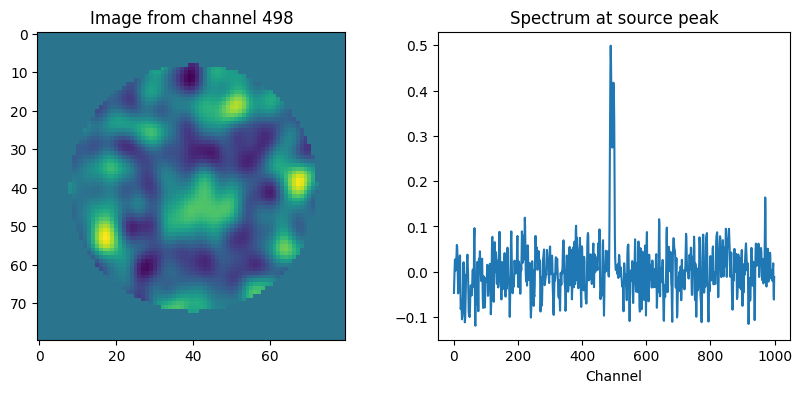

In [14]:
dispImage(imgname+'.residual',chanslice=498)

Imaging with updated JPL-Horizons ephemeris table

Get the same time range as the internal and time interval

In [15]:
for vis in msfile:
    ret=listobs(vis)
    calbegintime = qa.time(qa.quantity(ret['BeginTime'],'d'),form='ymd')[0]
    calendtime = qa.time(qa.quantity(ret['EndTime'],'d'),form='ymd')[0]
    bt = ret['BeginTime']
    print(f'mdj start: {bt}')
    print (f'observation time range : {calbegintime}~{calendtime}')
   # print(f'observation time range: {qa.time(qa.quantity(ret['BeginTime'],'d'),form='ymd')}~{qa.time(qa.quantity(str(ret['EndTime'])+'d'),form='ymd')}')

mdj start: 58377.42770666667
observation time range : 2018/09/16/10:15:54~2018/09/16/11:03:42
mdj start: 58383.51988666667
observation time range : 2018/09/22/12:28:38~2018/09/22/13:16:21


In [16]:
# full time range of the observations with some allowances
timerange='2018/09/16/10:15:54~2018/09/22/13:16:21'

In [17]:
interval = '1m'

## Imaging with external ephemeris table
Following steps describes that imaging with updated ephemeris table which is different from one used to track the source during observation. In that case the source image will be centered using the updated eph table while the original internal eph table will be used for re-phasing during gridding.

In [18]:
#clean up any tables from the previous runs
if os.path.exists('21PG-Z_JPL-Horizons_20180916-0922.tab'):
    import shutil
    shutil.rmtree('21PG-Z_JPL-Horizons_20180916-0922.tab')

In [19]:
getephemtable(objectname='90000322', asis=True, timerange=timerange, interval=interval, outfile='21PG-Z_JPL-Horizons_20180916-0922.tab', rawdatafile='myraw.dat',overwrite=True)

query params= b'format=json&EPHEM_TYPE=OBSERVER&OBJ_DATA=YES&COMMAND=%2790000322%27&START_TIME=2018%2F09%2F16%2F10%3A15%3A54&STOP_TIME=2018%2F09%2F22%2F13%3A16%3A21&STEP_SIZE=1m&CENTER=500%40399&QUANTITIES=%271%2C14%2C15%2C17%2C19%2C20%2C24%27&ANG_FORMAT=DEG'


2024-01-16 16:26:09	WARN	getephemtable::::casa	myraw.dat exists, will be overwritten


In [20]:
imgname2='tst-cubesrc-externaltable'

In [21]:
delete_tcleanimages(imgname2)

In [22]:
ret2=tclean(vis=msfile, field='21PGiacobini-Zinner', spw=['0', '0'], \
            antenna=['0,1,2,3,4,5,6,7,8,9,10,11', '0,1,2,3,4,5,6,7,8,9'], \
            scan=['7,11,15,19,23','8,12,16,20,24'], \
            intent='OBSERVE_TARGET#ON_SOURCE', datacolumn='data', \
            imagename=imgname, imsize=[80, 80], cell=['0.66arcsec'], \
            phasecenter='21PG-Z_JPL-Horizons_20180916-0922.tab', stokes='I', specmode='cubesource', \
            nchan=1000, start='354.4452721710GHz', width='0.1221004MHz', perchanweightdensity=True, \
            gridder='mosaic', mosweight=False, \
            usepointing=True, restoringbeam='common', pbcor=False, \
            weighting='briggsbwtaper', robust=0.5, npixels=0, niter=100, \
            threshold='0.0mJy', nsigma=0.0, usemask='auto'
            '-multithresh', sidelobethreshold=1.25, noisethreshold=5.0, \
            lownoisethreshold=2.0, negativethreshold=0.0, \
            minbeamfrac=0.1, growiterations=75, dogrowprune=True, \
            minpercentchange=1.0)



refEp = Epoch: 58377::10:15:58.8960 : Direction: [-0.0521548, 0.921945, 0.383793]
buildCoordSys : refCoord RA(rad) = 1.62731, Dec(rad) = 0.393901
2024-01-16 16:26:11	WARN	task_tclean::SIImageStore::Open existing Images (file /export/home/murasame/casamodular/cas13705/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 582)	 Mismatch in Csys latpoles between existing image on disk ([93.2407, 22.5723, 180, 22.5723]) and current imaging run ([93.2378, 22.5688, 180, 22.5688]) : The DirectionCoordinates have differing latpoles -- Resetting to match image on disk
2024-01-16 16:26:12	WARN	task_tclean::MeasIERS::findTab (file /export/home/murasame/casamodular/cas13705/casa6/casatools/casacore/measures/Measures/MeasIERS.cc, line 387)	Requested data table /export/home/murasame2/casadev/ephemimaging/demo/notebooks cannot be found in the searched directories:
2024-01-16 16:26:12	WARN	task_tclean::SynthesisImagerVi2::CubeMajorCycle (file /export/home/murasame/casamodular/cas13705

RuntimeError: Error in making PSF : One or more  of the cube section failed in de/gridding. Return values for the sections: [0]

In [ ]:
#displayImage(imgname2+'.residual', title='21P/G-Z with the external ephem table')